# Linear Models

First we need to load all the packages necessary for this notebook. In order to install the packages run pip install requirements.txt

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random

C:\Users\ANDREAS\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Next we get the data using the environment variable ```RESEARCH_DATA_PATH``` which should direct to the data folder of this project

In [3]:
DATA_PATH = os.environ.get("RESEARCH_DATA_PATH")

First we specify the the date range of the datasets that will be used and the test size, the number of folds for the cross validation and the grid of ragularization hyperparameters that we will use to tune our model.

In [4]:
# Define the start and end dates for the data range
start_date = '1985-01-31'
end_date = '2018-12-31'

# Specify the proportion of test data (e.g., 10%)
test_data_size = 0.2

# Set the number of splits for K-Fold Cross Validation
KFold_split = 5

# Specify a range of alpha values for Ridge regression
alphas = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]

Now we load the data used for our analysis. We are using six different datasets, namely:
1) MEF monthly data (X_mef_monthly) --> 408 points    
2) MEF daily data (X_mef_daily) --> 8523 points  
3) MAI monthly data (X_mai_monthly) --> 408 points  
4) MAI daily data (X_mai_daily) --> 8523 points   
5) Market monthly data (y_mkt_monthly) --> 408 points  
6) Market daily data (y_mkt_daily) --> 8523 points 

In [5]:
# UPLOAD MONTHLY DATA
X_mef_monthly = pd.read_csv(f'{DATA_PATH}/processed/mef_monthly_data_processed.csv')
X_mai_monthly = pd.read_csv(f'{DATA_PATH}/processed/mai_monthly_data_processed.csv')
y_mkt_monthly = pd.read_csv(f'{DATA_PATH}/processed/mkt_monthly_data_processed.csv')

X_mef_monthly['date'] = pd.to_datetime(X_mef_monthly['date'])
X_mai_monthly['date'] = pd.to_datetime(X_mai_monthly['date'])
y_mkt_monthly['date'] = pd.to_datetime(y_mkt_monthly['date'])

X_mef_monthly = X_mef_monthly[(X_mef_monthly['date'] >= start_date) & (X_mef_monthly['date'] <= end_date)]
X_mai_monthly = X_mai_monthly[(X_mai_monthly['date'] >= start_date) & (X_mai_monthly['date'] <= end_date)]
y_mkt_monthly = y_mkt_monthly[(y_mkt_monthly['date'] >= start_date) & (y_mkt_monthly['date'] <= end_date)]

# Drop the 'date' column from each dataset
X_mef_monthly = X_mef_monthly.drop('date', axis=1)
X_mai_monthly = X_mai_monthly.drop('date', axis=1)
y_mkt_monthly = y_mkt_monthly.drop('date', axis=1)

X_mef_monthly = X_mef_monthly.values
X_mai_monthly = X_mai_monthly.values
y_mkt_monthly = y_mkt_monthly.values

# UPLOAD DAILY DATA
X_mef_daily = pd.read_csv(f'{DATA_PATH}/processed/mef_daily_data_processed.csv')
X_mai_daily = pd.read_csv(f'{DATA_PATH}/processed/mai_daily_data_processed.csv')
y_mkt_daily = pd.read_csv(f'{DATA_PATH}/processed/mkt_daily_data_processed.csv')

X_mef_daily['date'] = pd.to_datetime(X_mef_daily['date'])
X_mai_daily['date'] = pd.to_datetime(X_mai_daily['date'])
y_mkt_daily['date'] = pd.to_datetime(y_mkt_daily['date'])

X_mef_daily = X_mef_daily[(X_mef_daily['date'] >= start_date) & (X_mef_daily['date'] <= end_date)]
X_mai_daily = X_mai_daily[(X_mai_daily['date'] >= start_date) & (X_mai_daily['date'] <= end_date)]
y_mkt_daily = y_mkt_daily[(y_mkt_daily['date'] >= start_date) & (y_mkt_daily['date'] <= end_date)]

# Drop the 'date' column from each dataset
X_mef_daily = X_mef_daily.drop('date', axis=1)
X_mai_daily = X_mai_daily.drop('date', axis=1)
y_mkt_daily = y_mkt_daily.drop('date', axis=1)

X_mef_daily = X_mef_daily.values
X_mai_daily = X_mai_daily.values
y_mkt_daily = y_mkt_daily.values

We define necessary functions for our model, that perform train-test split, hyperparameter selection, training - evaluation and prediction on new incoming data.

In [6]:
def split_data(X, y, train_size, indices):
    # Split indices into train and test indices
    train_indices, test_indices = indices[:train_size], indices[train_size:]

    # Split data based on the indices
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, y_train, X_test, y_test

In [7]:
def find_optimal_ridge_hyperparameters(X_train, y_train, alphas, KFold_split):
    optimal_degree = None
    optimal_alpha = None
    minimal_mse = float('inf')

    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    for alpha in alphas:
        kf = KFold(n_splits=KFold_split)
        mse_arr = []

        for train_index, test_index in kf.split(X_train_std):
            X_train_n, y_train_n = X_train_std[train_index], y_train[train_index]
            X_train_v, y_train_v = X_train_std[test_index], y_train[test_index]

            # Train Ridge regression
            ridge = Ridge(alpha=alpha)
            ridge.fit(X_train_n, y_train_n)

            # Predict and calculate MSE on the validation set
            y_pred = ridge.predict(X_train_v)
            mse = mean_squared_error(y_train_v, y_pred)
            mse_arr.append(mse)

        # Calculate the average MSE across KFold splits
        avg_mse = np.mean(mse_arr)

        # Update optimal hyperparameters if the current setup is better
        if avg_mse < minimal_mse:
            optimal_alpha = alpha
            minimal_mse = avg_mse

    return optimal_alpha, minimal_mse

In [8]:
def train_and_evaluate_ridge(X_train, y_train, X_test, y_test, alpha):
    # Train Ridge regression on the entire training set
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)

    # Predict on the training and test sets
    y_pred_train = ridge.predict(X_train)
    y_pred_test = ridge.predict(X_test)

    # Calculate MSE for the training and test sets
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Return the MSE values and the trained model
    return mse_train, mse_test, ridge

In [9]:
def predict_with_ridge_batch(model, scaler, X):
    # Standardize X using the same scaler used for training
    X_std = scaler.transform(X)

    # Predict the target values using the trained Ridge model
    predicted_y = model.predict(X_std)

    return predicted_y

## Ridge regression with monthly data

We remind that we use the described features to predict one month S&P500 annualized excess returns.

We train our model for the monthly datasets (MEF and MAI) of size 408. Since the datasets are small, in order to get more robust results, we train the models 10 times with a different train-test split every time and report the average RMSE for each of the two datasets.

In [10]:
# Training and evaluating Ridge model

# Set the random seed for reproducibility
np.random.seed(11)
random.seed(11)

# Generate a list of 10 different random permutations
all_indices = [np.random.permutation(X_mef_monthly.shape[0]) for _ in range(10)]

#lists to store the error of each iteration
MEF_errors_train = []
MEF_errors_test = []
MAI_errors_train = []
MAI_errors_test = []
 
train_size = int((1-test_data_size) * X_mef_monthly.shape[0])

for i in range(10):
    # Split data into training and test sets
    indices = all_indices[i]
    X_train_mef, y_train_mef, X_test_mef, y_test_mef = split_data(X_mef_monthly, y_mkt_monthly, train_size, indices)
    X_train_mai, y_train_mai, X_test_mai, y_test_mai = split_data(X_mai_monthly, y_mkt_monthly, train_size, indices)

    # Standardize both training and test data using a scaler
    scaler = StandardScaler()
    X_train_std_mef = scaler.fit_transform(X_train_mef)
    X_test_std_mef = scaler.transform(X_test_mef)  
    X_train_std_mai = scaler.fit_transform(X_train_mai)
    X_test_std_mai = scaler.transform(X_test_mai)

    # Find optimal alpha using cross-validation
    optimal_alpha_mef, minimal_mse_mef = find_optimal_ridge_hyperparameters(X_train_std_mef, y_train_mef, alphas, KFold_split)    
    optimal_alpha_mai, minimal_mse_mai = find_optimal_ridge_hyperparameters(X_train_std_mai, y_train_mai, alphas, KFold_split)

    # Evaluate the model on the test set (MEF)
    mse_train_mef, mse_test_mef, ridge_model_mef = train_and_evaluate_ridge(X_train_std_mef, y_train_mef, X_test_std_mef, y_test_mef, optimal_alpha_mef)
    y_pred_mef = ridge_model_mef.predict(X_test_std_mef)
    rmse_train_mef = mse_train_mef**(1/2)
    rmse_test_mef = mse_test_mef**(1/2)
 
    #add the resulting error in the list
    MEF_errors_train.append(rmse_train_mef)
    MEF_errors_test.append(rmse_test_mef)
    
    # Evaluate the model on the test set (MAI)
    mse_train_mai, mse_test_mai, ridge_model_mai = train_and_evaluate_ridge(X_train_std_mai, y_train_mai, X_test_std_mai, y_test_mai, optimal_alpha_mai)
    y_pred_mai = ridge_model_mai.predict(X_test_std_mai)
    rmse_train_mai = mse_train_mai**(1/2)
    rmse_test_mai = mse_test_mai**(1/2)
    
    MAI_errors_train.append(rmse_train_mai)
    MAI_errors_test.append(rmse_test_mai)

MEF_avg_rmse_train = sum(MEF_errors_train) / len(MEF_errors_train)   
MEF_avg_rmse_test = sum(MEF_errors_test) / len(MEF_errors_test)
print('MEF Linear Predictor')
print(f"Average Train RMSE for MEF monthly data: {MEF_avg_rmse_train}")
print(f"Average Test RMSE for MEF monthly data: {MEF_avg_rmse_test}")
print("")

MAI_avg_rmse_train = sum(MAI_errors_train) / len(MAI_errors_train)
MAI_avg_rmse_test = sum(MAI_errors_test) / len(MAI_errors_test)
print('MAI Linear Predictor')
print(f"Average Train RMSE for MAI monthly data: {MAI_avg_rmse_train}")
print(f"Average Test RMSE for MAI monthly data: {MAI_avg_rmse_test}")
print("")

MEF Linear Predictor
Average Train RMSE for MEF monthly data: 49.55525995028775
Average Test RMSE for MEF monthly data: 54.3068437868698

MAI Linear Predictor
Average Train RMSE for MAI monthly data: 50.39303867814994
Average Test RMSE for MAI monthly data: 53.57131816255678



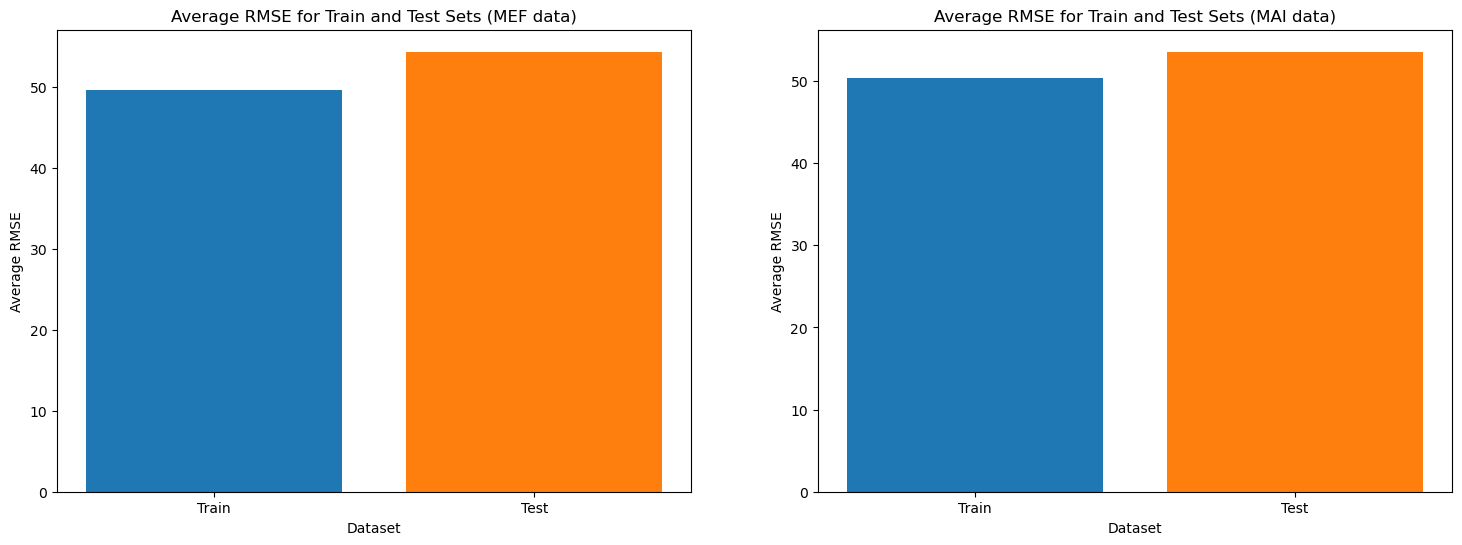

In [11]:
#Plot Average train and test errors

labels = ['Train', 'Test']
MEF_rmse_values = [MEF_avg_rmse_train, MEF_avg_rmse_test]
MAI_rmse_values = [MAI_avg_rmse_train, MAI_avg_rmse_test]

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.bar(labels, MEF_rmse_values, color=['#1f77b4', '#ff7f0e'])
plt.xlabel('Dataset')
plt.ylabel('Average RMSE')
plt.title('Average RMSE for Train and Test Sets (MEF data)')

plt.subplot(1,2,2)
plt.bar(labels, MAI_rmse_values, color=['#1f77b4', '#ff7f0e'])
plt.xlabel('Dataset')
plt.ylabel('Average RMSE')
plt.title('Average RMSE for Train and Test Sets (MAI data)')

plt.show()


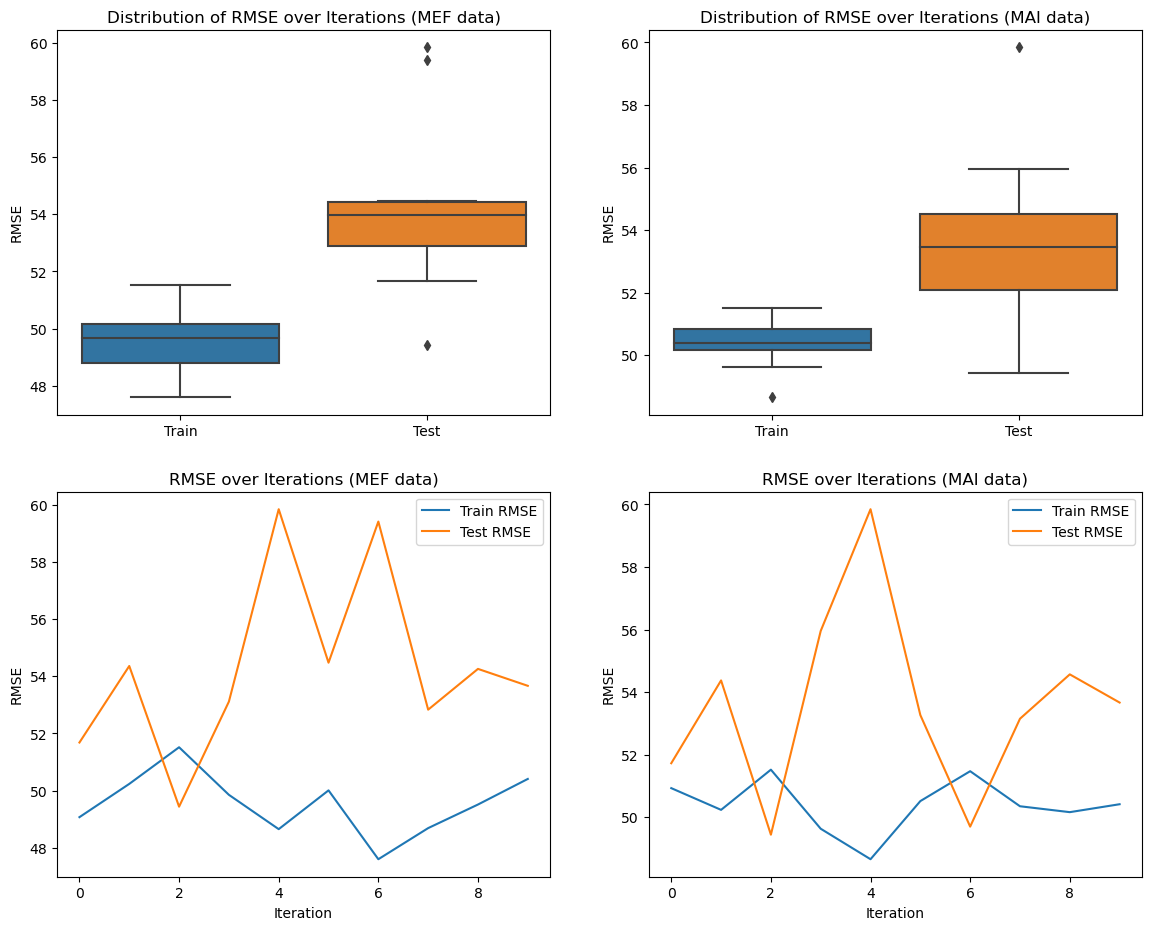

In [12]:
# Boxplots for distribution of errors over the 10 iterations
plt.figure(figsize=(14,11))
plt.subplot(2,2,1)
sns.boxplot(data=[MEF_errors_train, MEF_errors_test])
plt.xticks([0, 1], ['Train', 'Test'])
plt.ylabel('RMSE')
plt.title('Distribution of RMSE over Iterations (MEF data)')

plt.subplot(2,2,2)
sns.boxplot(data=[MAI_errors_train, MAI_errors_test])
plt.xticks([0, 1], ['Train', 'Test'])
plt.ylabel('RMSE')
plt.title('Distribution of RMSE over Iterations (MAI data)')

plt.subplot(2, 2, 3)
plt.plot(MEF_errors_train, label='Train RMSE')
plt.plot(MEF_errors_test, label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE over Iterations (MEF data)')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(MAI_errors_train, label='Train RMSE')
plt.plot(MAI_errors_test, label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE over Iterations (MAI data)')
plt.legend()
plt.show()


We notice that the error is very high. If we actually look at the predictions, we notice that the model always predicts zero. This comes from the fact that the regression coefficients are all close to zero. This indicates that maybe the features we are using are not informative, that further preprocessing needs to be done or that the relationship of the features to the target variable is highly non-linear so it cannot be captured by the regression model.

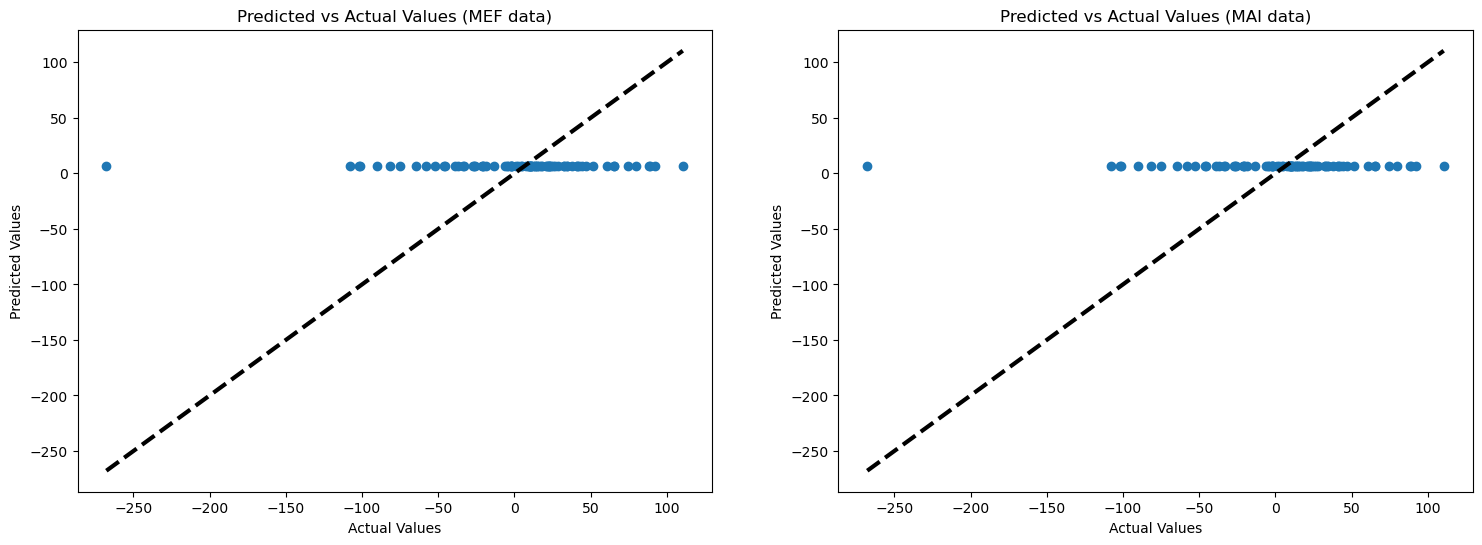

In [13]:
# For MEF data
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.scatter(y_test_mef, y_pred_mef)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (MEF data)')
plt.plot([y_test_mef.min(), y_test_mef.max()], [y_test_mef.min(), y_test_mef.max()], 'k--', lw=3)


# For MAI data
plt.subplot(1,2,2)
plt.scatter(y_test_mai, y_pred_mai)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (MAI data)')
plt.plot([y_test_mai.min(), y_test_mai.max()], [y_test_mai.min(), y_test_mai.max()], 'k--', lw=3)
plt.show()



In [14]:
# For MEF model
print("Coefficients of the trained MEF model:", ridge_model_mef.coef_)

# For MAI model
print("Coefficients of the trained MAI model:", ridge_model_mai.coef_)


Coefficients of the trained MEF model: [[ 0.01859789  0.01893145  0.01635675 -0.00041333 -0.02984222  0.01527115
   0.0106116   0.00380644  0.00376947  0.00481132 -0.00104717 -0.00799363
   0.01119646 -0.00029917]]
Coefficients of the trained MAI model: [[-0.00809317 -0.00829523 -0.00525982 -0.00915623 -0.01498522 -0.00955155
   0.00860803 -0.00684544]]


## Ridge regression with daily data

Now we do the same for the MAI and MEF daily datasets of size 8523. We remind here, that the daily data for the MEF features were constructed by us. Since the dataset now is larger, we don't train the model multiple times but only once, and report the train and test RMSE.

In [15]:
# Set the random seed for reproducibility
np.random.seed(8)
random.seed(8)

train_size = int((1-test_data_size) * X_mai_daily.shape[0])
indices = np.random.permutation(X_mai_daily.shape[0])

np.random.shuffle(indices)
X_train_mai_d, y_train_mai_d, X_test_mai_d, y_test_mai_d = split_data(X_mai_daily, y_mkt_daily, train_size, indices)
X_train_mef_d, y_train_mef_d, X_test_mef_d, y_test_mef_d = split_data(X_mef_daily, y_mkt_daily, train_size, indices)

scaler = StandardScaler()
X_train_std_mai_d = scaler.fit_transform(X_train_mai_d)
X_test_std_mai_d = scaler.transform(X_test_mai_d) 

X_train_std_mef_d = scaler.fit_transform(X_train_mef_d)
X_test_std_mef_d = scaler.transform(X_test_mef_d) 

optimal_alpha_mai, minimal_mse_mai = find_optimal_ridge_hyperparameters(X_train_std_mai_d, y_train_mai_d, alphas, KFold_split)    
optimal_alpha_mef, minimal_mse_mef = find_optimal_ridge_hyperparameters(X_train_std_mef_d, y_train_mef_d, alphas, KFold_split)    
  
mse_train_mai, mse_test_mai, ridge_model_mai = train_and_evaluate_ridge(X_train_std_mai_d, y_train_mai_d, X_test_std_mai_d, y_test_mai_d, optimal_alpha_mai)
rmse_train_mai = mse_train_mai**(1/2)
rmse_test_mai = mse_test_mai**(1/2)

print(f"Train RMSE for MAI daily data: {rmse_train_mai}")
print(f"Test RMSE for MAI daily data: {rmse_test_mai}")
print("")

mse_train_mef, mse_test_mef, ridge_model_mef = train_and_evaluate_ridge(X_train_std_mef_d, y_train_mef_d, X_test_std_mef_d, y_test_mef_d, optimal_alpha_mef)
rmse_train_mef = mse_train_mef**(1/2)
rmse_test_mef = mse_test_mef**(1/2)

print(f"Train RMSE for MEF daily data: {rmse_train_mef}")
print(f"Test RMSE for MEF daily data: {rmse_test_mef}")
print("")


Train RMSE for MAI daily data: 54.06338073127046
Test RMSE for MAI daily data: 54.677498294772924

Train RMSE for MEF daily data: 52.597683017539026
Test RMSE for MEF daily data: 53.243184900001204



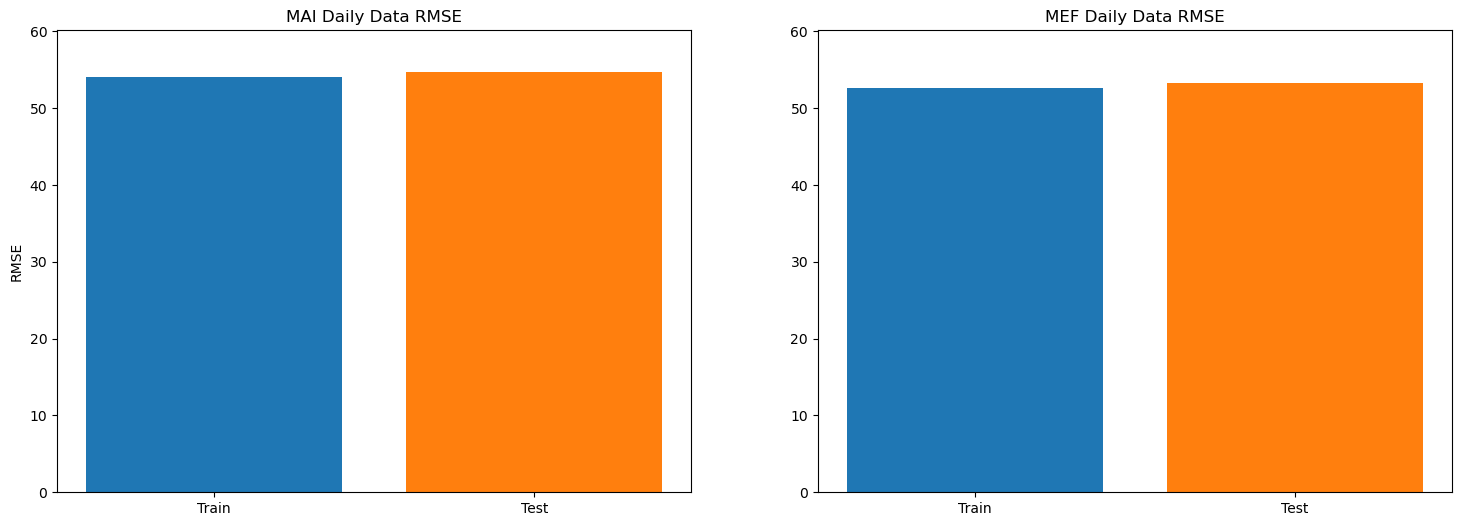

In [16]:
# Train and Test RMSE values
rmse_values_mai = [rmse_train_mai, rmse_test_mai]
rmse_values_mef = [rmse_train_mef, rmse_test_mef]

# Labels for the bar plots
labels = ['Train', 'Test']

# Create two subplots in a row
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot for MAI data
axs[0].bar(labels, rmse_values_mai, color=['#1f77b4', '#ff7f0e'])
axs[0].set_title('MAI Daily Data RMSE')
axs[0].set_ylabel('RMSE')
axs[0].set_ylim([0, max(rmse_values_mai + rmse_values_mef) * 1.1])  # Adjust y-axis limits

# Plot for MEF data
axs[1].bar(labels, rmse_values_mef, color=['#1f77b4', '#ff7f0e'])
axs[1].set_title('MEF Daily Data RMSE')
axs[1].set_ylim([0, max(rmse_values_mai + rmse_values_mef) * 1.1])  # Adjust y-axis limits

plt.show()


So even with the larger dataset of the daily data, we notice again a similar very large error, so we derive that the lack of predictive power of the model cannot be assigned to the small dataset

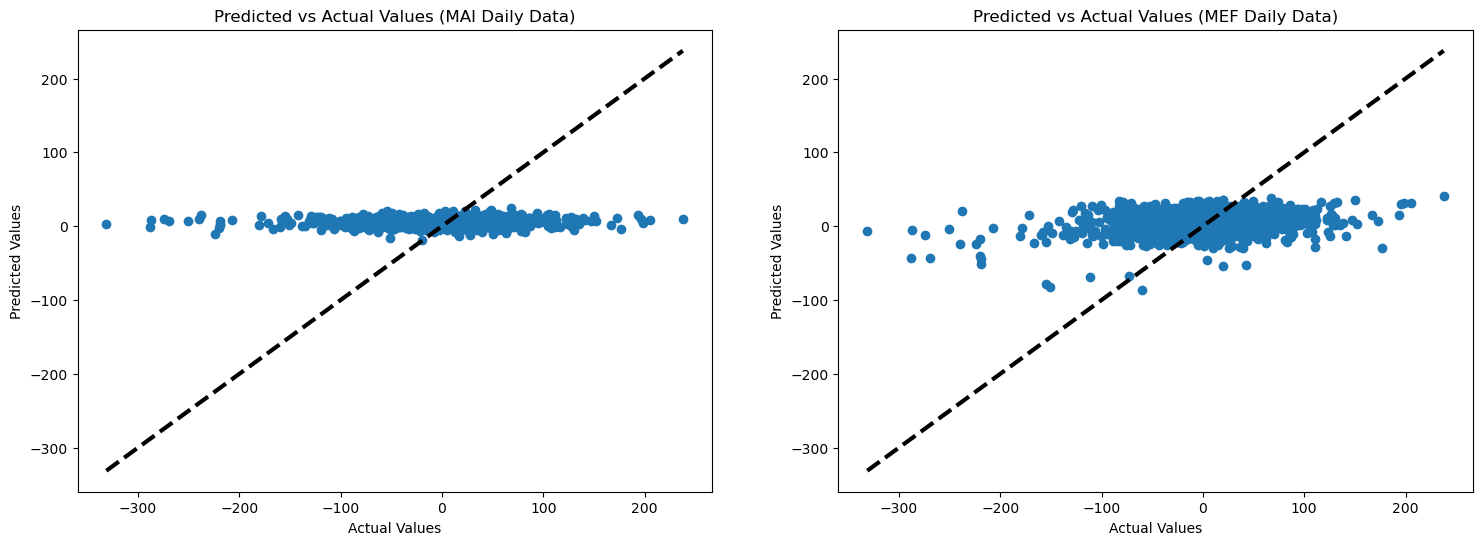

In [17]:
y_pred_mai_d = ridge_model_mai.predict(X_test_std_mai_d)
y_pred_mef_d = ridge_model_mef.predict(X_test_std_mef_d)

# Create two subplots in a row for scatter plots
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Scatter plot for MAI data
axs[0].scatter(y_test_mai_d, y_pred_mai_d)
axs[0].plot([y_test_mai_d.min(), y_test_mai_d.max()], [y_test_mai_d.min(), y_test_mai_d.max()], 'k--', lw=3)
axs[0].set_xlabel('Actual Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Predicted vs Actual Values (MAI Daily Data)')

# Scatter plot for MEF data
axs[1].scatter(y_test_mef_d, y_pred_mef_d)
axs[1].plot([y_test_mef_d.min(), y_test_mef_d.max()], [y_test_mef_d.min(), y_test_mef_d.max()], 'k--', lw=3)
axs[1].set_xlabel('Actual Values')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Predicted vs Actual Values (MEF Daily Data)')

plt.show()


In [18]:
# Coefficients of trained model
# For MEF model
print("Coefficients of the trained MEF model:", ridge_model_mef.coef_)

# For MAI model
print("Coefficients of the trained MAI model:", ridge_model_mai.coef_)

Coefficients of the trained MEF model: [[ 47.34314384 -46.06390492  21.22877691  18.94699736  -7.07384469
   -7.6572383    5.42163295  -3.45364872  -7.8054984   -2.60264411
   -7.03776417   6.37954896   8.92745244   4.31709891]]
Coefficients of the trained MAI model: [[-1.75641536  0.44429982 -2.36716731 -0.84334885 -1.14078549 -0.66843841
   2.71801436  0.4210063 ]]
